In [22]:
import os
import torch
import torchaudio
import IPython.display as ipd
# import matplotlib
# matplotlib.use('qt5agg')
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
from torchvision import transforms, datasets
from pathlib import Path
import soundfile as sf
import pandas as pd
from torchaudio.compliance.kaldi import spectrogram
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from collections import Counter


# CNN with images of spectrograms



## Explore noWhale


In [3]:
# audio NoWhale
waveform_noWhale, sr_noWhale = torchaudio.load(r'.\train\train\0.wav')

print(type(waveform_noWhale))
print(type(sr_noWhale))
print(waveform_noWhale.shape)
# 2000 data points per second, in total 4000 data points
print(sr_noWhale)


<class 'torch.Tensor'>
<class 'int'>
torch.Size([1, 4000])
2000


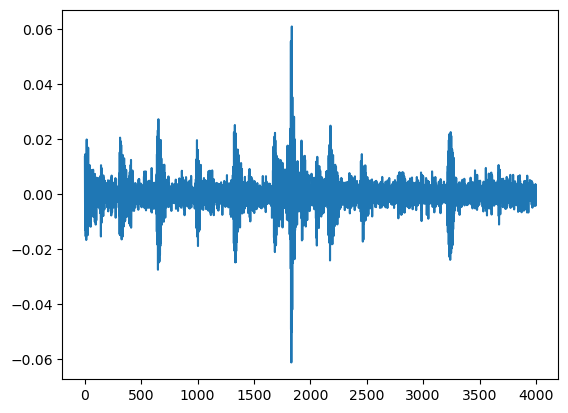

In [4]:
plt.figure()
plt.plot(waveform_noWhale.t().numpy())


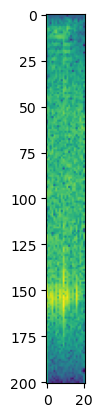

In [5]:
# Spectrogram
spectrogram_noWhale = torchaudio.transforms.Spectrogram()(waveform_noWhale)
# plot the spectrogram
plt.figure()
# scale the values with log2 and then select the first channel
plt.imshow(spectrogram_noWhale.log2()[0,:,:].numpy(), cmap='viridis')

## Explore RightWhale

In [6]:
# audio RightWhale
waveform_rightWhale, sr_rightWhale = torchaudio.load(r'.\train\train\1.wav')

print(type(waveform_rightWhale))
print(type(sr_rightWhale))
print(waveform_rightWhale.shape)
# 2000 data points per second, in total 4000 data points
print(sr_rightWhale)



<class 'torch.Tensor'>
<class 'int'>
torch.Size([1, 4000])
2000


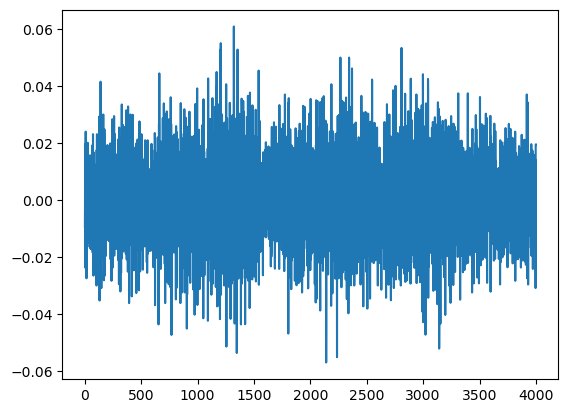

In [7]:
plt.figure()
plt.plot(waveform_rightWhale.t().numpy())


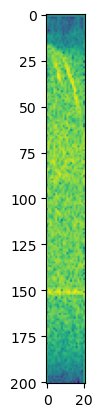

In [8]:
# Spectrogram
spectrogram_rightWhale = torchaudio.transforms.Spectrogram()(waveform_rightWhale)
# plot the spectrogram
plt.figure()
# scale the values with log2 and then select the first channel
plt.imshow(spectrogram_rightWhale.log2()[0,:,:].numpy(), cmap='viridis')


## Load data

In [9]:
# collect all the paths in the train folder
sound_files = os.listdir(r'.\train\train')
df_labels = pd.read_csv(r'.\train.csv')
print(len(sound_files))

10944


In [10]:
# get labels
train_labels = df_labels['class'].to_numpy()
print(train_labels[:10])
print(len(train_labels))

['NoWhale' 'RightWhale' 'NoWhale' 'NoWhale' 'NoWhale' 'NoWhale'
 'RightWhale' 'NoWhale' 'NoWhale' 'RightWhale']
10934


In [11]:
# remove the audios that are not valid
idx_labeled_audio_files = df_labels['idx'].to_numpy()
available_audio_files = []
for file in sound_files:
    try:
        idx = int(file.split('.')[0])
        available_audio_files.append(idx)
    except:
        print("Invalid file: ", file)

Invalid file:  8675(1).wav
Invalid file:  8676(1).wav
Invalid file:  8677(1).wav
Invalid file:  8678(1).wav
Invalid file:  8679(1).wav
Invalid file:  868(1).wav
Invalid file:  8680(1).wav
Invalid file:  8681(1).wav
Invalid file:  8682(1).wav
Invalid file:  8684(1).wav


In [12]:
available_audio_files = sorted(available_audio_files)
print(available_audio_files[:5])

[0, 1, 2, 3, 4]


In [13]:
# split the valid audio files into noWhale and RightWhale
noWhale_paths = []
rightWhale_paths = []
# assign the paths to the corresponding label
for idx in available_audio_files:
    if train_labels[idx] == 'NoWhale':
        noWhale_paths.append(idx)
    elif train_labels[idx] == 'RightWhale':
        rightWhale_paths.append(idx)
    else:
        print("Invalid label: ", train_labels[idx])

print(len(noWhale_paths))
print(len(rightWhale_paths))

5467
5467


In [14]:
# get the complete path of the valid audio files
noWhale_paths = [os.path.join(r'.\train\train', str(file) + '.wav') for file in noWhale_paths]
rightWhale_paths = [os.path.join(r'.\train\train', str(file) + '.wav') for file in rightWhale_paths]
print(noWhale_paths[:5])
print(rightWhale_paths[:5])

['.\\train\\train\\0.wav', '.\\train\\train\\2.wav', '.\\train\\train\\3.wav', '.\\train\\train\\4.wav', '.\\train\\train\\5.wav']
['.\\train\\train\\1.wav', '.\\train\\train\\6.wav', '.\\train\\train\\9.wav', '.\\train\\train\\10.wav', '.\\train\\train\\14.wav']


## Process data : Get images

In [15]:

if not os.path.exists(r'.\train_images_spectrogram'):
    os.makedirs(r'.\train_images_spectrogram\noWhale')
    os.makedirs(r'.\train_images_spectrogram\rightWhale')

    # save the spectrogram images of the noWhale

    for j, path in enumerate(noWhale_paths):
        if j % 1000 == 0:
            print(j)
        idx = int(path.split('\\')[-1].split('.')[0])
        waveform, sr = torchaudio.load(path)

        spectrogram_noWhale = torchaudio.transforms.Spectrogram()(waveform)
        spectrogram_path = os.path.join(r'.\train_images_spectrogram\noWhale', str(idx) + '.png')
        # scale the values with log2 and then select the first channel

        plt.imsave(spectrogram_path, spectrogram_noWhale.log2()[0,:,:].numpy(), cmap='viridis')
        j = j + 1

    # save the spectrogram images of the rightWhale

    for j, path in enumerate(rightWhale_paths):
        if j % 1000 == 0:
            print(j)
        idx = int(path.split('\\')[-1].split('.')[0])
        waveform, sr = torchaudio.load(path)

        spectrogram_rightWhale = torchaudio.transforms.Spectrogram()(waveform)
        spectrogram_path = os.path.join(r'.\train_images_spectrogram\rightWhale', str(idx) + '.png')
        # scale the values with log2 and then select the first channel

        plt.imsave(spectrogram_path, spectrogram_rightWhale.log2()[0,:,:].numpy(), cmap='viridis')
        j = j + 1



In [19]:
# Plot the unique dimensions of the images
path_rightWhale_directory = r'.\train_images_spectrogram\rightWhale'
path_noWhale_directory = r'.\train_images_spectrogram\noWhale'

image_noWhale_paths = os.listdir(path_noWhale_directory)
image_rightWhale_paths = os.listdir(path_rightWhale_directory)

# paths of all the images
image_noWhale_paths = [os.path.join(path_noWhale_directory, path) for path in image_noWhale_paths]
image_rightWhale_paths = [os.path.join(path_rightWhale_directory, path) for path in image_rightWhale_paths]

# get the dimensions of spectrogram images
image_dimensions = []
for path in image_noWhale_paths:
    image = plt.imread(path)
    image_dimensions.append(image.shape)
for path in image_rightWhale_paths:
    image = plt.imread(path)
    image_dimensions.append(image.shape)
print(set(image_dimensions))
"""
All the images have the same dimensions, so its not necessary to resize them to uniform dimensions
"""


{(201, 21, 4)}


In [27]:
# This function will allow you to load and split your images into a test_loader and a train_loader

def load_images(images_path, batch_size, seed=10):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    #valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp']

    images_dataset = datasets.ImageFolder(images_path, transform=transform)

    try:
        train_len = int(0.68 * len(images_dataset))
        test_len = len(images_dataset) - train_len

        train_dataset, test_dataset = random_split(images_dataset, [train_len, test_len], generator=torch.Generator().manual_seed(seed))


        train_classes = []
        for _, label in train_dataset:
            train_classes.append(label)
        print("Classes", Counter(train_classes))
        
        train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size, num_workers=2)
        test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size, num_workers=2)

        return train_loader, test_loader
    except ValueError as e:
        print(f"ValueError: {e}")
        return None, None


In [28]:
train_loader, test_loader = load_images(r'.\train_images_spectrogram', batch_size=30)

Classes Counter({0: 3723, 1: 3712})


## CNN model for spectrogram images

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
# Hiperparámetros
num_classes = 2
learning_rate = 0.0001
num_epochs = 5
batch_size = 30

dp1 = nn.Dropout(p=0.2)
dp2 = nn.Dropout(p=0.2)
dp3 = nn.Dropout(p=0.2)
dp4 = nn.Dropout(p=0.2)


import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            dp1,
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            dp2,
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            dp3,
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=9, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            dp4,
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Linear(13*13*256, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc2(out)
        return out